#  Прогнозирование заказов такси

### Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

---

<h2>Содержание</h2>

<div class="toc">
  <ul>
    <li><a href="#Подготовка">Подготовка</a></li>
    <li><a href="#Анализ">Анализ</a></li>
    <li><a href="#Обучение">Обучение</a></li>
       <ul>
        <li><a href="#RandomForestRegressor">RandomForestRegressor</a></li>
        <li><a href="#CatBoostRegressor">CatBoostRegressor</a></li>
        <li><a href="#LightGBM">LightGBM</a></li>
      </ul>
    <li><a href="#Тестирование">Тестирование</a></li>
    <li><a href="#Общий-вывод">Общий вывод</a></li>
  </ul>
</div>

<style>
  .toc ul {
    font-size: 14px;
  }
</style>

---

### Цели и задачи

**Цель** - нужно спрогнозировать количество заказов такси на следующий час.

**Задачи**:
    
    1. Загрузить данные и выполнить их ресемплирование по одному часу.  
    2. Проанализировать данные.
    3. Обучить разные модели и сравнить их качество метрикой RMSE.
    4. Выбрать лучшую модели и проверить ее на тестовой выборке.
    5. Сделать выводы исследования.

---

### Описание данных

Количество заказов находится в столбце `num_orders`. 

---

## Подготовка

In [2]:
import pandas as pd 
import numpy as np

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/datasets/taxi.csv", parse_dates=[0], index_col=0)

In [4]:
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
print(df.index.is_monotonic)

True


Данные идут по порядку, периодичность интервала между данными 10 мин, ресемплируем их.

In [6]:
df = df.resample('1H').sum()

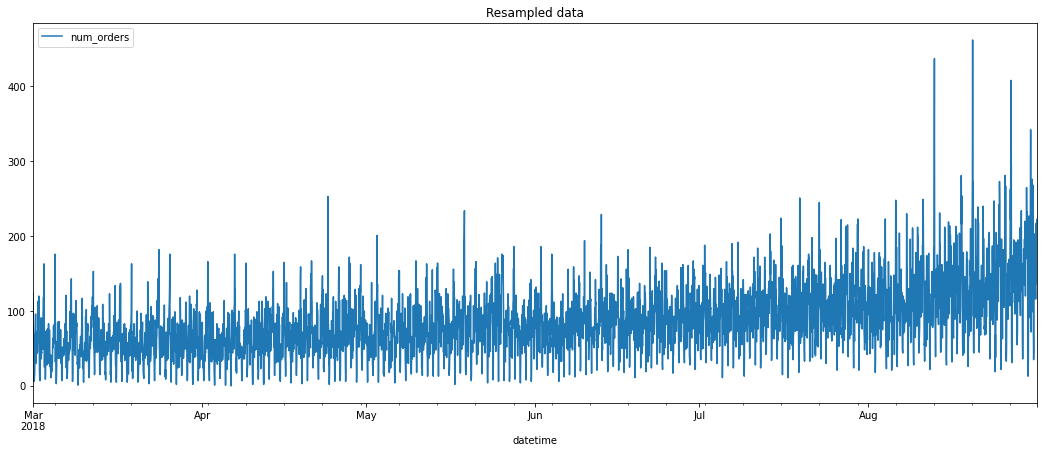

In [7]:
df.plot(figsize=(18, 7))
plt.title('Resampled data')
plt.show()

In [8]:
df_analys = df.copy()

Сделаем копию данных для анализа

## Анализ

In [9]:
decomposed = seasonal_decompose(df_analys)

In [10]:
# графики
def decomposed_show (decomposed_data):
    decomposed_data.trend.plot(figsize=(15, 5))
    plt.title('Trend')
    plt.show()

    decomposed_data.seasonal.plot(figsize=(15, 5))
    plt.title('Seasonality')
    plt.show()

    decomposed_data.resid.plot(figsize=(15, 5))
    plt.title('Residuals')
    plt.show()

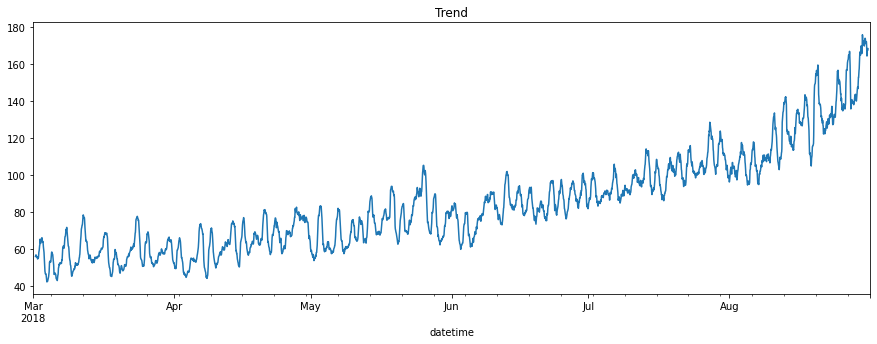

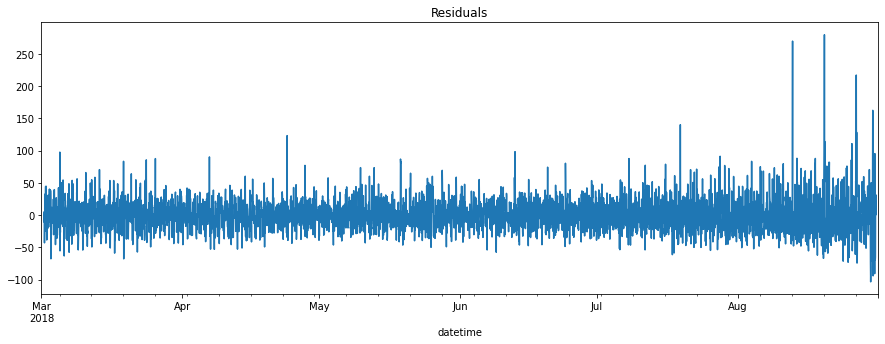

In [11]:
    decomposed.trend.plot(figsize=(15, 5))
    plt.title('Trend')
    plt.show()

    decomposed.resid.plot(figsize=(15, 5))
    plt.title('Residuals')
    plt.show()

Тренд в общем растет, то есть кол-во заказов и пользователей растет.

Посмотрим данные за месяц и неделю.

In [12]:
decomposed_month = seasonal_decompose(df_analys['2018-06-1':'2018-06-30'])

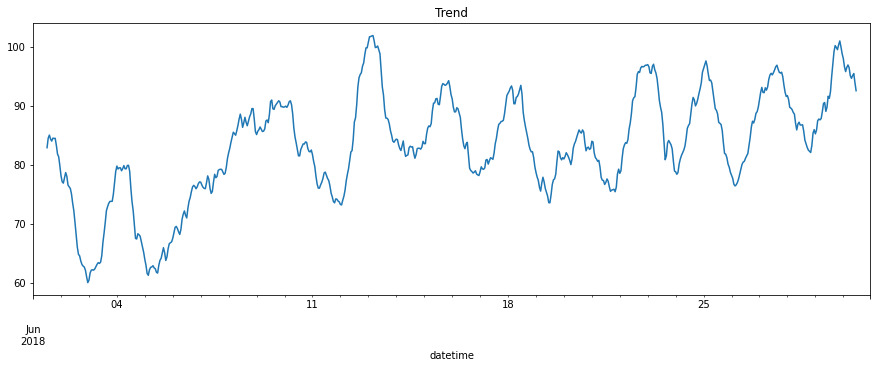

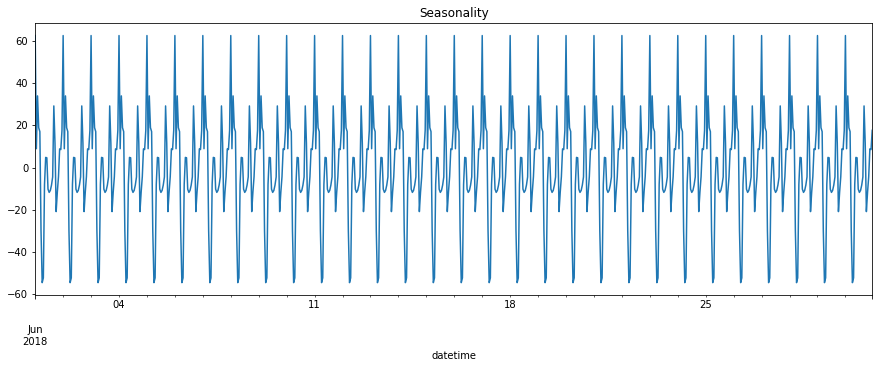

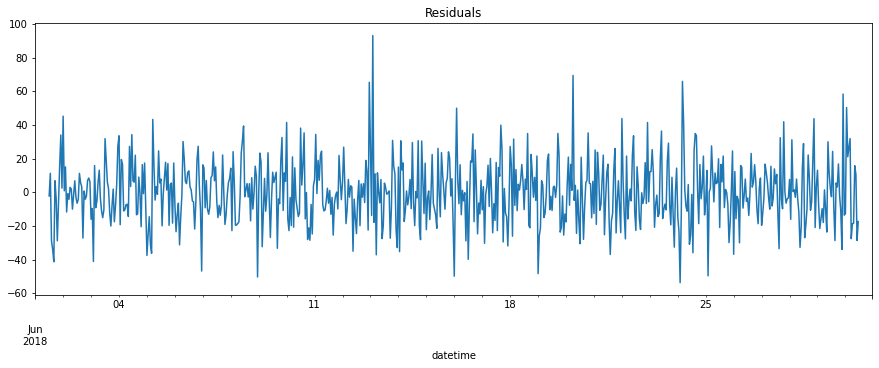

In [13]:
decomposed_show (decomposed_month)

In [14]:
decomposed_week = seasonal_decompose(df_analys['2018-06-1':'2018-06-7'])

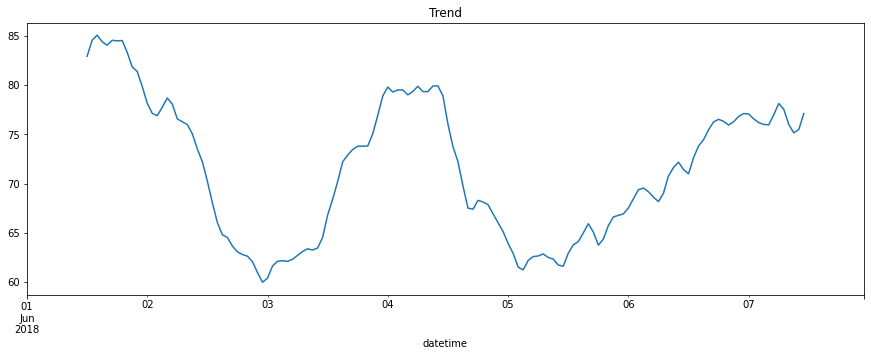

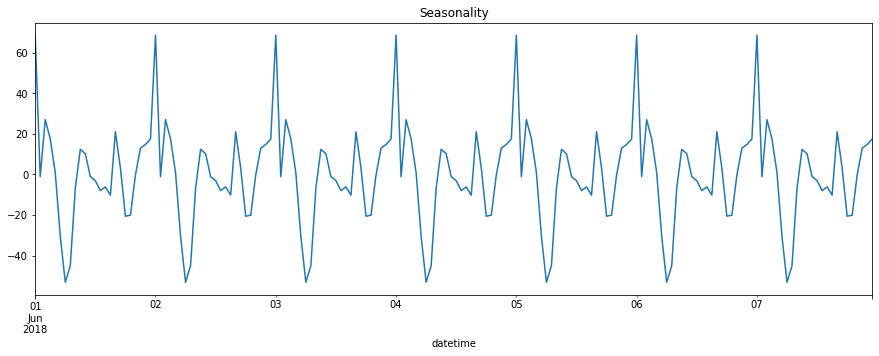

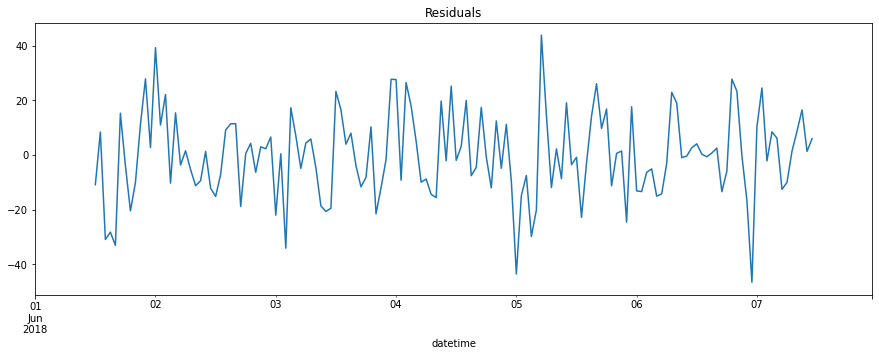

In [15]:
decomposed_show (decomposed_week)

Сезонный цикл длится в течении дня, ранним утром такси пользуются минимальным спросом, в течении дня спрос растет и достигает своего пика около полуночи.

In [16]:
df_analys = df_analys - df_analys.shift() 
df_analys["rolling_mean"] = df_analys["num_orders"].rolling(20).mean()
df_analys["rolling_std"] = df_analys["num_orders"].rolling(20).std()

In [17]:
def graph (data):

    data.plot(figsize=(15, 8))
    plt.show()

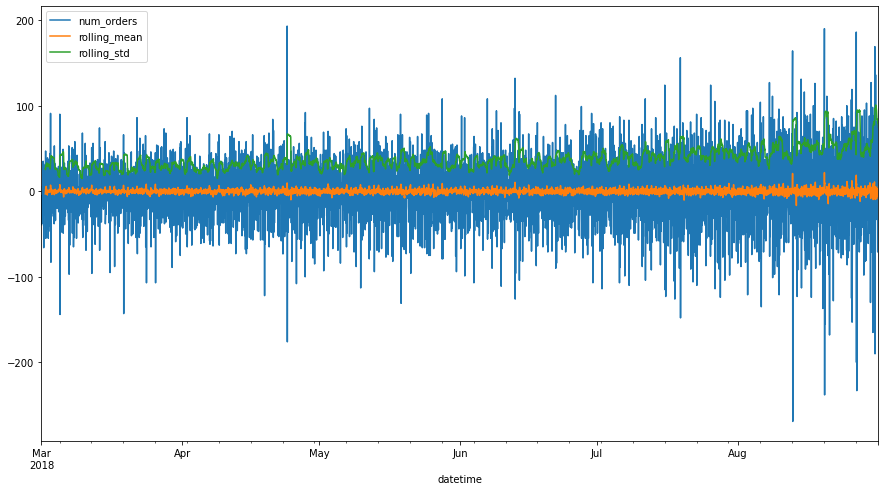

In [18]:
graph (df_analys)

На первый взгляд ряд стационарен. Проверим данные , проведем обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [19]:
tes = df['num_orders']
test = adfuller(tes)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен.')
else:
    print ('Единичных корней нет, ряд стационарен.')

adf:  -3.0689242890279558
p-value:  0.028940051402612906
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен.


### Вывод

* Дисперсия увеличичвается.
* Тренд в общем растет, то есть кол-во заказов и пользователей растет.
* Временной ряд стационарен.

## Обучение

Создадим признаки.

Календарные признаки:
* Неделя - тренд
* День - сезон
* Час - прогнозируемый признак

Отстающие значения:
* max_lag - 24 (часа в сутках)

Скользящее среднее
* rolling_size - 30 (месяц)

In [20]:
# Признаки
def make_features(data, column, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data["hour"] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].rolling(rolling_mean_size).mean().shift()

In [21]:
# создаем признаки
make_features(df, 'num_orders', 24, 30)

In [22]:
# делаем выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [23]:
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=7)

#### RandomForestRegressor

In [24]:
%%time
# RandomForest
parametrs = {"max_depth": [6,8], 
             "n_estimators":[50,100,150]}

RF = RandomForestRegressor(random_state=54321)
RF_grid = GridSearchCV(RF, parametrs, cv = splits, verbose=True, n_jobs=-1, scoring = "neg_root_mean_squared_error")
RF_grid.fit(features_train, target_train)
rmse_rf = RF_grid.best_score_ * -1    
print("RMSE обученной модели:", rmse_rf)  

Fitting 7 folds for each of 6 candidates, totalling 42 fits
RMSE обученной модели: 25.307972952908166
CPU times: user 1min 10s, sys: 312 ms, total: 1min 10s
Wall time: 1min 11s


#### CatBoostRegressor

In [25]:
%%time
# CatBoost
parameters_cat = {'depth':[5,10], 
                  'learning_rate':np.arange(0.1, 0.2, 0.3)}

catboost = CatBoostRegressor(loss_function='RMSE',random_state = 54321, iterations=300)
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(features_train, target_train), cv=splits, verbose=True)

final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(features_train, target_train))
rmse_cat = final_cat.get_best_score()    
print("RMSE обученной модели:", rmse_cat["learn"]["RMSE"]) 

0:	learn: 72.5153959	test: 107.1884217	best: 107.1884217 (0)	total: 53.1ms	remaining: 15.9s
1:	learn: 66.4105343	test: 100.2309685	best: 100.2309685 (1)	total: 59.1ms	remaining: 8.81s
2:	learn: 61.0427874	test: 94.1139687	best: 94.1139687 (2)	total: 64.9ms	remaining: 6.42s
3:	learn: 56.1677539	test: 88.1534611	best: 88.1534611 (3)	total: 71ms	remaining: 5.26s
4:	learn: 51.8930273	test: 82.8978523	best: 82.8978523 (4)	total: 77.5ms	remaining: 4.57s
5:	learn: 48.0265901	test: 78.0140819	best: 78.0140819 (5)	total: 83.7ms	remaining: 4.1s
6:	learn: 44.6387629	test: 74.2317618	best: 74.2317618 (6)	total: 87.9ms	remaining: 3.68s
7:	learn: 41.8371577	test: 70.8958373	best: 70.8958373 (7)	total: 92ms	remaining: 3.36s
8:	learn: 39.1751918	test: 67.1952770	best: 67.1952770 (8)	total: 96.1ms	remaining: 3.11s
9:	learn: 36.9358507	test: 64.3855132	best: 64.3855132 (9)	total: 100ms	remaining: 2.9s
10:	learn: 34.8437131	test: 61.4132145	best: 61.4132145 (10)	total: 105ms	remaining: 2.75s
11:	learn: 3

#### LightGBM

In [26]:
%%time
# LightGBM
parameters_light = {'max_depth':[10],
                    "learning_rate":np.arange(0.1,1,0.2)}


lgb_train = lgb.LGBMRegressor(metric= 'RMSE', random_state= 54321, objective='regression', boosting_type = "gbdt")
lgb_grid = GridSearchCV(lgb_train, parameters_light, cv = splits, verbose=True, n_jobs=-1, scoring = "neg_root_mean_squared_error")
light = lgb_grid.fit(features_train, target_train)
rmse_lgb= light.best_score_ * -1    
print("RMSE обученной модели:", rmse_lgb) 

Fitting 7 folds for each of 5 candidates, totalling 35 fits
RMSE обученной модели: 24.738723029501063
CPU times: user 43.8 s, sys: 331 ms, total: 44.1 s
Wall time: 44.6 s


In [27]:
# выводим результаты
comparison_tabl = pd.DataFrame(index=['Качество моделей'], columns=['LightGBM','CatBoostRegressor','RandomForestRegressor'])
comparison_tabl['LightGBM'] = rmse_lgb
comparison_tabl['CatBoostRegressor'] = rmse_cat["learn"]["RMSE"]
comparison_tabl['RandomForestRegressor'] = rmse_rf
comparison_tabl

,LightGBM,CatBoostRegressor,RandomForestRegressor
Качество моделей,24.738723,9.060282,25.307973


### Вывод
Было использовано 3 регрессионных модели и были получены их результаты. Подготовка к тестированию завершена. Catboost показал лучшие результаты, на ней и проведем тестирование.

## Тестирование

In [28]:
model = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)

model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE = np.sqrt(mean_squared_error(target_test, target_predict))

0:	learn: 36.9589271	total: 4.2ms	remaining: 4.2s
100:	learn: 20.6225836	total: 387ms	remaining: 3.44s
200:	learn: 17.7707500	total: 784ms	remaining: 3.12s
300:	learn: 16.0937351	total: 1.19s	remaining: 2.77s
400:	learn: 14.5450886	total: 1.67s	remaining: 2.5s
500:	learn: 13.2643451	total: 2.07s	remaining: 2.06s
600:	learn: 12.1855193	total: 2.46s	remaining: 1.63s
700:	learn: 11.2585738	total: 2.85s	remaining: 1.22s
800:	learn: 10.3912616	total: 3.25s	remaining: 807ms
900:	learn: 9.6782609	total: 3.64s	remaining: 400ms
999:	learn: 9.0602818	total: 4.03s	remaining: 0us


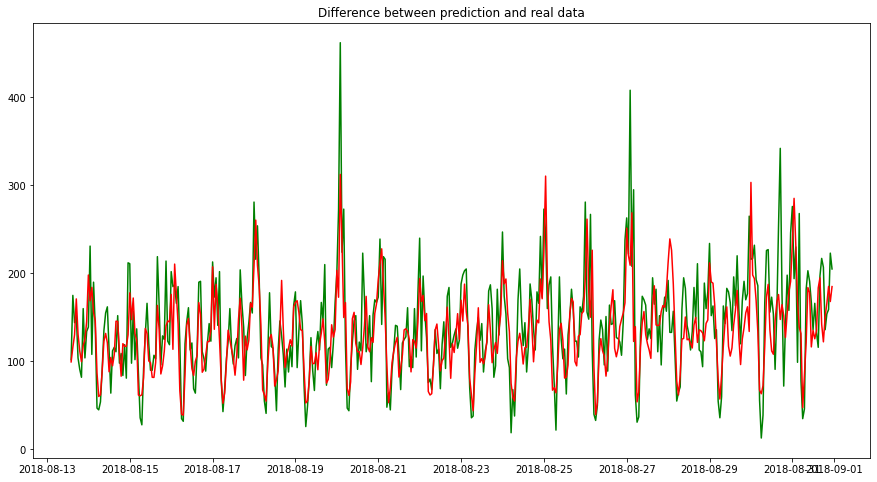

In [29]:
plt.figure(figsize=(15, 8))
plt.plot(target_test.index, 
         target_test, 
         'g-', 
         target_test.index, 
         target_predict,
         'r-')
plt.title('Difference between prediction and real data')
plt.show()

In [30]:
print("Итоговое RMSE модели CatBoost:", final_RMSE)

Итоговое RMSE модели CatBoost: 41.46552172233096


Исходя из графика, можно предположить, что модель плохо прогнозирует выбросы. Значение метрики RMSE меньше 48, что соответствует условию задачи. 

## Общий вывод
* Загрузил данные и выполнил ресемплирование по одному часу.
* Провел анализ полученного временного ряда.
* Обучил такие модели как *RandomForestRegressor*, *CatBoostRegressor*, *LightGBM*. Проверенно их качество.
* Проверил данные на тестовой выборке. Значение метрики RMSE модели CatBoost на тестовой выборке меньше 48.